# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 3: benchmarking on audio dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

# audio signal augmentation packages
import audiomentations
import torch_audiomentations
from audiomentations import Compose, AddGaussianNoise, BandPassFilter, Gain, HighPassFilter
from audiomentations import Normalize

from torch_audiomentations import PolarityInversion

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

from audio_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns
from itertools import cycle
import itertools


In [33]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'class_name_v2','train_audio')
os.makedirs(IMAGE_PATH, exist_ok=True)

model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'class_name_v2', 'audio_model')
os.makedirs(model_path, exist_ok=True)

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [3]:
classes = ('Defect-free', 'Defective', 'Laser-off')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 25

### Utils

In [4]:
def plot_data_distribution(data, variable, title, filename, figure_size=(7, 6)):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Create the countplot
    sns.countplot(x=variable, data=data, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5, ax=ax, alpha = 0.9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Add percentages above each bar
    total = len(data)
    max_height = 0
    for p in ax.patches:
        max_height = max(max_height, p.get_height())
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')
    
    # Extend the y-axis for better visibility of annotations
    ax.set_ylim([0, max_height * 1.2])
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel("Categories", fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Add grid
    ax.grid(True, which='both', axis='y', linestyle='dotted', linewidth=0.5, alpha=0.7, color='black')
    
    # Show all four edges of the plot
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    # Show the plot
    plt.tight_layout()
    save_fig(f"{filename}.png")
    plt.show()

### Use GPU if possible

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
mp.set_start_method(method='forkserver', force=True)

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [6]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name'])

df_multimodal

,sample index,Time_Stamps,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,rms_energy,amplitude_envelope_mean,...,center_y,contour_area,contour_length,X,Y,Z,Vx,Vy,Vz,Speed
0,1,0.00,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,0.009018,0.003034,...,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,2,0.04,sample_21_2.wav,sample_21_2.jpg,Defect-free,Defect-free,1.0,21,0.019286,0.012109,...,239.000000,305442.0,2234.000000,0.000,-0.000,0.001,-0.074,-0.074,0.000,0.105
2,3,0.08,sample_21_3.wav,sample_21_3.jpg,Defect-free,Defect-free,1.0,21,0.019593,0.015114,...,239.000000,305442.0,2234.000000,-0.010,0.015,-0.007,-0.051,0.026,-0.051,0.077
3,4,0.12,sample_21_4.wav,sample_21_4.jpg,Defect-free,Defect-free,1.0,21,0.030937,0.021501,...,230.264496,291865.5,2279.781744,-0.007,0.016,0.010,0.173,-0.222,2.520,2.536
4,5,0.16,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,0.038329,0.029851,...,229.109962,281970.0,2407.847760,-0.111,0.123,-0.057,-1.864,1.662,-2.468,3.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48461,10982,439.24,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,Laser-off,NaN,26,0.011000,0.009066,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48462,10983,439.28,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,Laser-off,NaN,26,0.008347,0.006188,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48463,10984,439.32,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,Laser-off,NaN,26,0.011081,0.007763,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48464,10985,439.36,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,Laser-off,NaN,26,0.011044,0.007960,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080


In [7]:
# Get the labels and count the number of samples for each class
labels = df_multimodal['class_name_v2'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 8993  5806 18147]


In [8]:
def get_sample_directories_from_df(df, Dataset_path):
    # Extract unique sample numbers from the DataFrame
    unique_sample_numbers = df['Sample number'].unique()
    
    # Generate the full paths for image and audio directories
    image_directories = [os.path.join(Dataset_path, str(sample_number), 'images') for sample_number in unique_sample_numbers]
    audio_directories = [os.path.join(Dataset_path, str(sample_number), 'raw_audio') for sample_number in unique_sample_numbers]
    
    return image_directories, audio_directories

samples = [21, 22, 23, 24, 26, 32]
image_directories, audio_directories = get_sample_directories_from_df(df_multimodal, Dataset_path)

### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **55%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [9]:
### Get the percentage distribution of each category
round(df_multimodal.groupby('class_name_v2')["class_name_v2"].count()/df_multimodal.shape[0]*100, 1)

class_name_v2
Defect-free    27.3
Defective      17.6
Laser-off      55.1
Name: class_name_v2, dtype: float64

Saving figure dataset_distribution.png


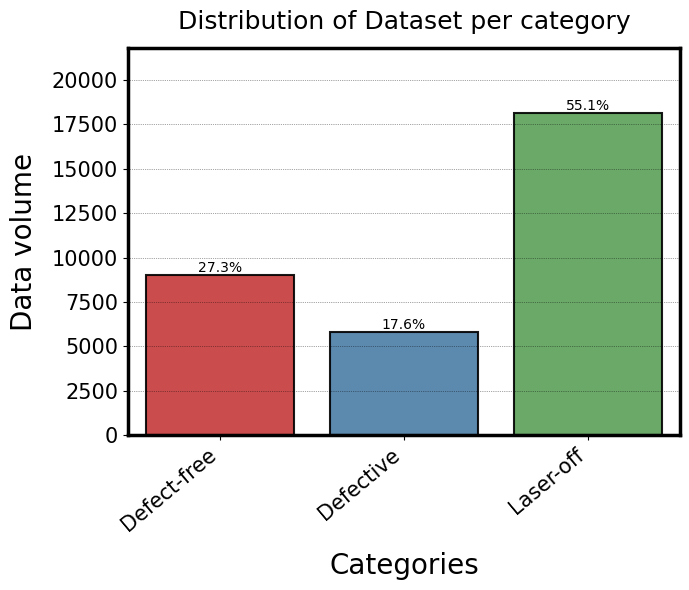

In [10]:
plot_data_distribution(df_multimodal, 'class_name_v2', 
                       'Distribution of Dataset per category', 'dataset_distribution')

## Preparing Dataset and DataLoader

In [11]:
#------ transformation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)



augmentation = Compose(
    [
       AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.002, p=0.5),
       # HighPassFilter(min_cutoff_freq=1000, max_cutoff_freq=21000, p=0.5),
       BandPassFilter(min_center_freq=1000, max_center_freq=21000, p=0.5),
       # Gain(min_gain_in_db = -2, max_gain_in_db = 2, p=0.5),
       Normalize(p=0.5)
    ]
)


# Initialize augmentation callable
apply_augmentation = Compose(
    transforms=[
        # Gain(
        #     min_gain_in_db=-15.0,
        #     max_gain_in_db=5.0,
        #     p=0.5,
        # ),
        PolarityInversion(p=0.5)
    ]
)

train_transform = transforms.Compose([
    augmentation,
    apply_augmentation,
    # torchaudio.transforms.TimeMasking(time_mask_param=20, p=0.5),  # apply time masking with probability of 0.5
    # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),  # apply time masking with probability of 0.5
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=32),  # compute Mel-frequency cepstral coefficients (MFCCs)
])


In [12]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(df_multimodal,
                                audio_directories,
                                samples,
                                mel_spectrogram,
                                # MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

length of the total dataset:32946


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [13]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(df_multimodal, labels))

# split the data into train and test sets
train_annotations = df_multimodal.iloc[train_indices, :]
test_annotations = df_multimodal.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = LDEDAudioDataset(train_annotations,
                                 audio_directories,
                                 samples, 
                                 mel_spectrogram,
                                 SAMPLE_RATE,
                                 device=device)

val_dataset = LDEDAudioDataset(test_annotations,
                               audio_directories,
                               samples,
                               mel_spectrogram,
                               SAMPLE_RATE,
                               device=device)

### Create DataLoader using the dataset

In [14]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:26356
length of the val dataset:6590


## Training the model

In [15]:
resume = False
start_epoch = 0
best_acc = 0

In [16]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
    # train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
    # test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
    # scheduler.step()

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.823, accuracy=75.3]


17:00:51 --- Epoch: 0	Train loss: 0.9579	Valid loss: 0.0257	Train accuracy: 65.18	Valid accuracy: 75.33

Epoch: 1


Epoch 1:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.783, accuracy=77.3]


17:01:18 --- Epoch: 1	Train loss: 0.8168	Valid loss: 0.0245	Train accuracy: 73.79	Valid accuracy: 77.34

Epoch: 2


Epoch 2:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.768, accuracy=78.6]


17:01:45 --- Epoch: 2	Train loss: 0.7914	Valid loss: 0.0240	Train accuracy: 76.04	Valid accuracy: 78.57

Epoch: 3


Epoch 3:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.753, accuracy=80.1]


17:02:12 --- Epoch: 3	Train loss: 0.7761	Valid loss: 0.0236	Train accuracy: 77.62	Valid accuracy: 80.11

Epoch: 4


Epoch 4:   0%|                                                                                                                                            | 0/206 [00:10<?, ?it/s, loss=0.742, accuracy=81]


17:02:40 --- Epoch: 4	Train loss: 0.7626	Valid loss: 0.0232	Train accuracy: 79.07	Valid accuracy: 80.99

Epoch: 5


Epoch 5:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.732, accuracy=82.1]


17:03:08 --- Epoch: 5	Train loss: 0.7523	Valid loss: 0.0229	Train accuracy: 80.07	Valid accuracy: 82.09

Epoch: 6


Epoch 6:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.725, accuracy=82.5]


17:03:35 --- Epoch: 6	Train loss: 0.7427	Valid loss: 0.0226	Train accuracy: 80.96	Valid accuracy: 82.55

Epoch: 7


Epoch 7:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.713, accuracy=84.2]


17:04:03 --- Epoch: 7	Train loss: 0.7320	Valid loss: 0.0223	Train accuracy: 82.10	Valid accuracy: 84.16

Epoch: 8


Epoch 8:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.709, accuracy=84.3]


17:04:30 --- Epoch: 8	Train loss: 0.7250	Valid loss: 0.0222	Train accuracy: 82.80	Valid accuracy: 84.32

Epoch: 9


Epoch 9:   0%|                                                                                                                                            | 0/206 [00:10<?, ?it/s, loss=0.7, accuracy=85.3]


17:04:57 --- Epoch: 9	Train loss: 0.7171	Valid loss: 0.0219	Train accuracy: 83.54	Valid accuracy: 85.34

Epoch: 10


Epoch 10:   0%|                                                                                                                                           | 0/206 [00:10<?, ?it/s, loss=0.694, accuracy=86]


17:05:24 --- Epoch: 10	Train loss: 0.7126	Valid loss: 0.0217	Train accuracy: 84.02	Valid accuracy: 86.02

Epoch: 11


Epoch 11:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.689, accuracy=86.5]


17:05:52 --- Epoch: 11	Train loss: 0.7051	Valid loss: 0.0215	Train accuracy: 84.82	Valid accuracy: 86.48

Epoch: 12


Epoch 12:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.683, accuracy=87.3]


17:06:18 --- Epoch: 12	Train loss: 0.7001	Valid loss: 0.0213	Train accuracy: 85.31	Valid accuracy: 87.33

Epoch: 13


Epoch 13:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.679, accuracy=87.6]


17:06:46 --- Epoch: 13	Train loss: 0.6959	Valid loss: 0.0212	Train accuracy: 85.84	Valid accuracy: 87.63

Epoch: 14


Epoch 14:   0%|                                                                                                                                           | 0/206 [00:10<?, ?it/s, loss=0.675, accuracy=88]


17:07:14 --- Epoch: 14	Train loss: 0.6908	Valid loss: 0.0211	Train accuracy: 86.32	Valid accuracy: 87.97

Epoch: 15


Epoch 15:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.675, accuracy=87.9]


17:07:42 --- Epoch: 15	Train loss: 0.6876	Valid loss: 0.0211	Train accuracy: 86.68	Valid accuracy: 87.94

Epoch: 16


Epoch 16:   0%|                                                                                                                                          | 0/206 [00:10<?, ?it/s, loss=0.67, accuracy=88.3]


17:08:08 --- Epoch: 16	Train loss: 0.6847	Valid loss: 0.0209	Train accuracy: 86.96	Valid accuracy: 88.29

Epoch: 17


Epoch 17:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.668, accuracy=88.6]


17:08:35 --- Epoch: 17	Train loss: 0.6821	Valid loss: 0.0209	Train accuracy: 87.11	Valid accuracy: 88.57

Epoch: 18


Epoch 18:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.667, accuracy=88.8]


17:09:02 --- Epoch: 18	Train loss: 0.6795	Valid loss: 0.0209	Train accuracy: 87.45	Valid accuracy: 88.80

Epoch: 19


Epoch 19:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.664, accuracy=88.7]


17:09:29 --- Epoch: 19	Train loss: 0.6781	Valid loss: 0.0208	Train accuracy: 87.47	Valid accuracy: 88.66

Epoch: 20


Epoch 20:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.663, accuracy=88.9]


17:09:56 --- Epoch: 20	Train loss: 0.6769	Valid loss: 0.0207	Train accuracy: 87.60	Valid accuracy: 88.94

Epoch: 21


Epoch 21:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.662, accuracy=89.1]


17:10:24 --- Epoch: 21	Train loss: 0.6748	Valid loss: 0.0207	Train accuracy: 87.83	Valid accuracy: 89.07

Epoch: 22


Epoch 22:   0%|                                                                                                                                         | 0/206 [00:09<?, ?it/s, loss=0.661, accuracy=89.1]


17:10:52 --- Epoch: 22	Train loss: 0.6735	Valid loss: 0.0207	Train accuracy: 87.93	Valid accuracy: 89.09

Epoch: 23


Epoch 23:   0%|                                                                                                                                         | 0/206 [00:10<?, ?it/s, loss=0.661, accuracy=89.1]


17:11:20 --- Epoch: 23	Train loss: 0.6719	Valid loss: 0.0206	Train accuracy: 88.07	Valid accuracy: 89.09

Epoch: 24


Epoch 24:   0%|                                                                                                                                         | 0/206 [00:09<?, ?it/s, loss=0.658, accuracy=89.3]

17:11:46 --- Epoch: 24	Train loss: 0.6696	Valid loss: 0.0206	Train accuracy: 88.33	Valid accuracy: 89.29


In [17]:
valid_accuracy

[75.32625189681336,
 77.34446130500758,
 78.57359635811837,
 80.10622154779969,
 80.98634294385432,
 82.09408194233687,
 82.54931714719271,
 84.1578148710167,
 84.3247344461305,
 85.34142640364188,
 86.02427921092564,
 86.47951441578148,
 87.32928679817906,
 87.63277693474961,
 87.96661608497723,
 87.93626707132019,
 88.28528072837632,
 88.57359635811837,
 88.80121396054628,
 88.66464339908953,
 88.93778452200303,
 89.07435508345979,
 89.08952959028832,
 89.08952959028832,
 89.28679817905918]

Saving figure train_lost_curve_audio


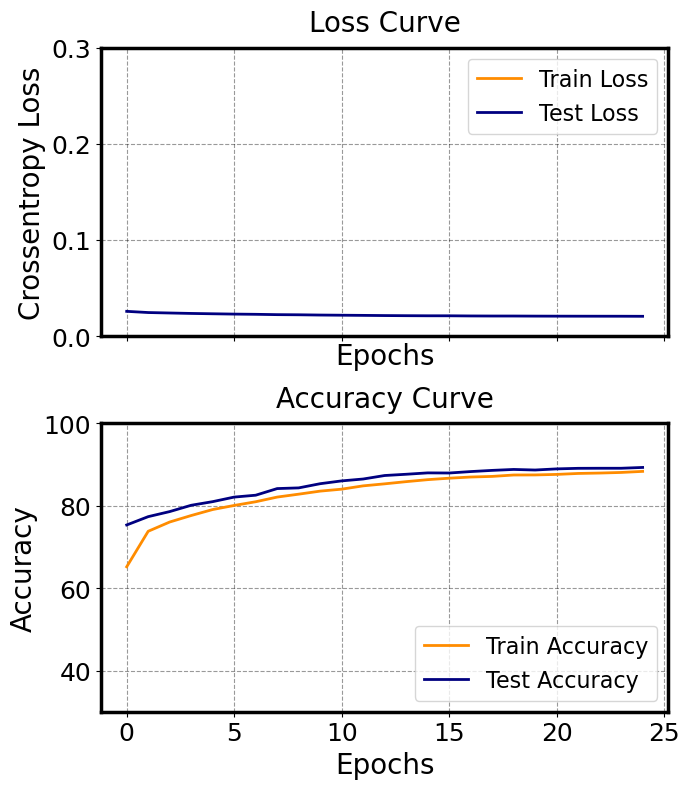

In [21]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 25, "Initial Training",
              interval=5, yloss_limit1=0, yloss_limit2=0.3, yacc_limit1=30, yacc_limit2=100)

save_fig ("train_lost_curve_audio")

In [22]:
get_accuracy(model, val_dataloader, device)

0.8928679817905918

Test Accuracy (cross-validation) for MFCC-CNN = 0.89287 ± 0.00965
micro-averaging AUC for MFCC-CNN = 0.93949 ± 0.00000
Saving figure ROC_curve (acoustic-based)-raw


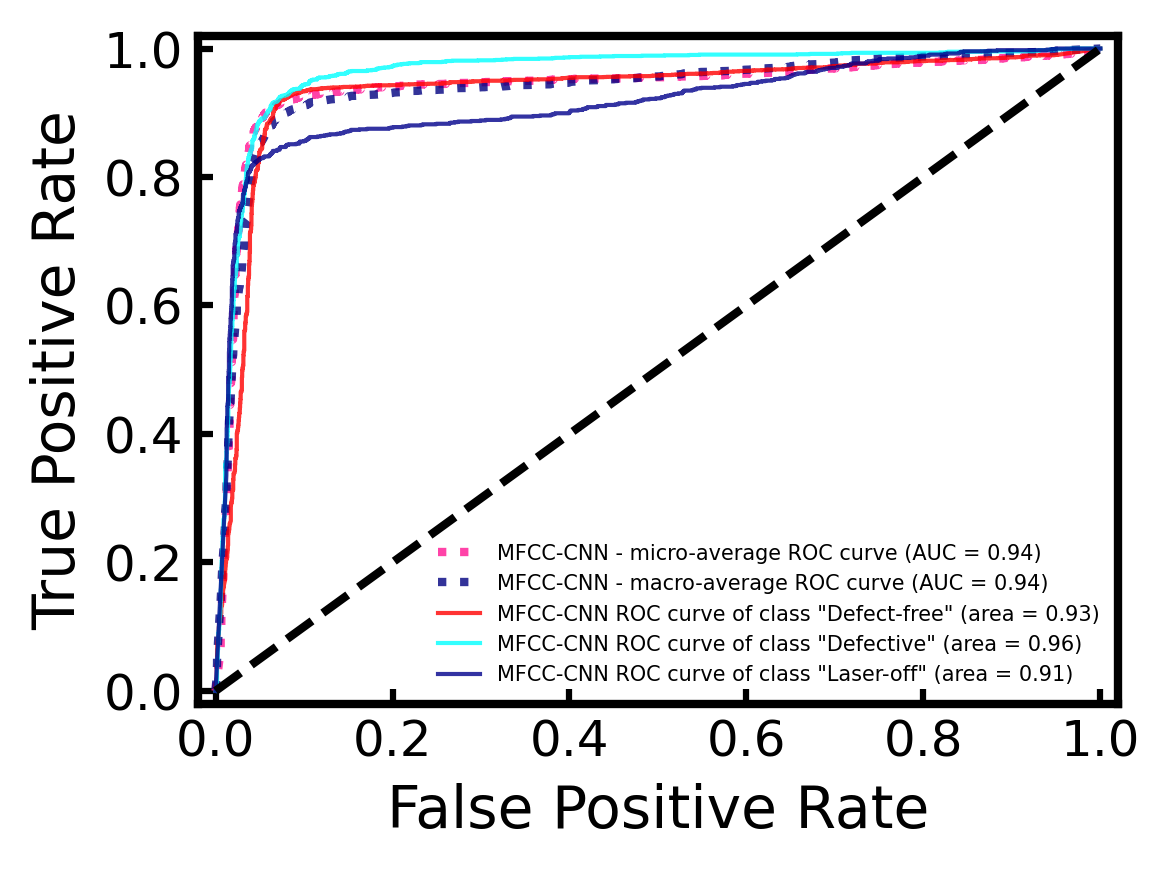

In [28]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", 
                                                                            signal_type = "raw", seed=0)

save_fig ("ROC_curve (acoustic-based)-raw")

In [26]:
yt, yp = class_report(model, val_dataloader, device, classes)

              precision    recall  f1-score   support

 Defect-free     0.9327    0.9242    0.9285      3630
   Defective     0.8562    0.8938    0.8746      1799
   Laser-off     0.8260    0.7933    0.8093      1161

    accuracy                         0.8929      6590
   macro avg     0.8717    0.8705    0.8708      6590
weighted avg     0.8930    0.8929    0.8928      6590



[[3355  154  121]
 [ 118 1608   73]
 [ 124  116  921]]
Saving figure confusion_matrix(audio_based)-raw


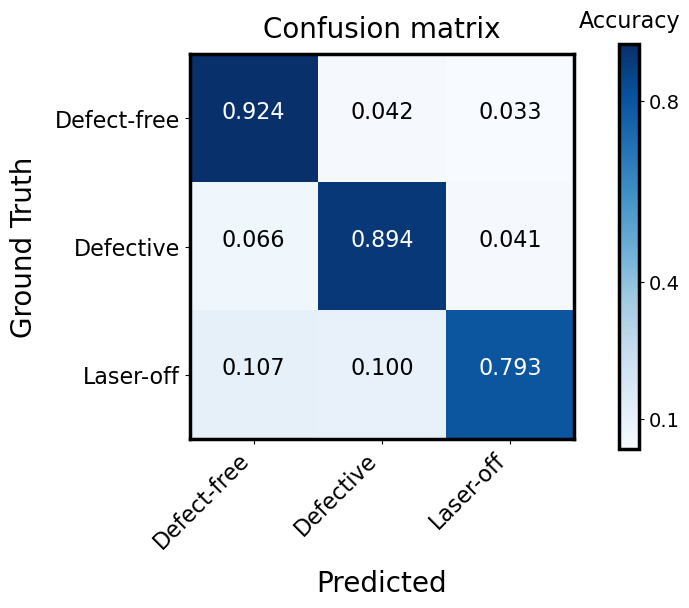

In [29]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_based)-raw")

### Save the trained model into the folder

In [34]:
# Save the model's state_dict
torch.save(model.state_dict(), os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth'))

# Load the trained model to test

In [35]:
# Initialize your model
model = nn.DataParallel(MFCCCNN())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the state dictionary
model.load_state_dict(torch.load(os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth')))


model.eval()  # Set the model to evaluation mode

DataParallel(
  (module): MFCCCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.2, inplace=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=3584, out_features=128, bias=True)
    (dropout3): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=128, out_features=3, bias=True)
    (softmax): Softmax(dim=1)
  )
)

### Random testing

Predicted label index: 2
Predicted class name: Defective


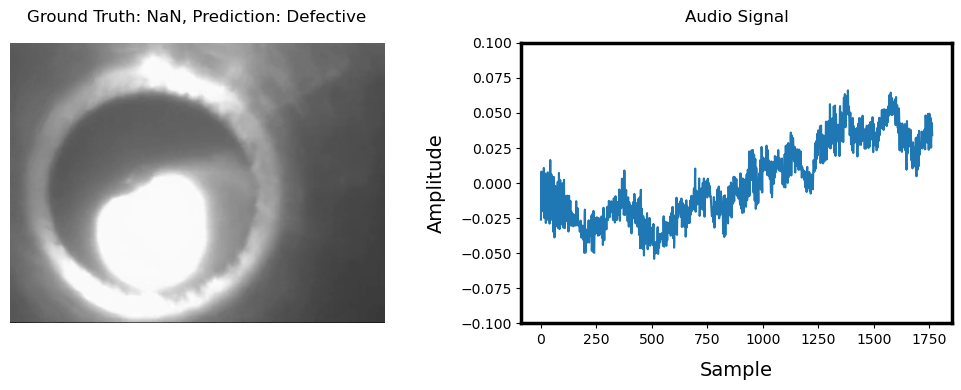

In [65]:
import PIL.Image

# Load and preprocess the image
sample_number = 32
index = 12600
img_path = os.path.join(Dataset_path, f"{sample_number}/images/sample_{sample_number}_{index}.jpg")
audio_path = os.path.join(Dataset_path, f"{sample_number}/raw_audio/sample_{sample_number}_{index}.wav")
input_image = PIL.Image.open(img_path).convert('L')  
# apply transform
waveform, sample_rate = torchaudio.load(audio_path)
waveform = waveform.to(device)
input_tensor = mel_spectrogram(waveform)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input to the GPU if available
input_batch = input_batch.to(device)

# Make the prediction
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get the label, use argmax to get the index of the maximum score
_, predicted_label_index = torch.max(output, 1)


print(f"Predicted label index: {predicted_label_index.item()}")


# (1) Map the predicted index to the actual class name
index_to_class = {
    0: 'Laser-off',
    1: 'Defect-free',
    2: 'Defective'
}

predicted_class_name = index_to_class[predicted_label_index.item()]
print(f"Predicted class name: {predicted_class_name}")

# (2) Display the image and print the ground truth label
try:
    ground_truth_label = df_multimodal.loc[
        (df_multimodal['Sample number'] == sample_number) & 
        (df_multimodal['image_file_name'] == f"sample_{sample_number}_{index}.jpg"), 
        'class_name_v2'
    ].iloc[0]
except IndexError:
    ground_truth_label = "NaN"


# Display the image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title(f"Ground Truth: {ground_truth_label}, Prediction: {predicted_class_name}", pad=15)
plt.axis('off')

# Load and plot the audio signal
waveform, sample_rate = torchaudio.load(audio_path)
plt.subplot(1, 2, 2)
plt.plot(waveform.t().numpy())
plt.title('Audio Signal', pad=15)
plt.xlabel('Sample', labelpad=10)
plt.ylabel('Amplitude', labelpad=10)
plt.ylim([-0.1, 0.1])
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()